<h2><center> EEG - N. 9 </center></h2>

<h3><center> MANU 465 101 </center></h3>

[Set phase](#Set-phase)

 - [Import libraries](#Import-libraries)
 - [Setting path](#Setting-path)

[Features generation](#Features-generation)


[Import procedure](#Import-procedure)
  - [Lists initialization](#Lists-initialization)
  - [Final dataset creation](#Final-dataset-creation)
       
[Conclusions](#Conclusions)
       

# Introduction
The following is the code for MANU 465 EEG Group #9 Capstone Project. The code is written in Python and uses the following libraries:

-   Pandas
-   Numpy
-   Matplotlib
-   Seaborn
-   Scikit-learn

## Objective 
Our objective is to use machine learning to determine if a person is left or right handed based on brainwave data using brainwave data collected by the MUSE 2. Muse 2 is a multi-sensor electroencephalograph (EEG) device that provides real-time biofeedback on brain activity, heartbeat, breathing, and movement by attaching a set of electrodes to the scalp to measure the electrical activity of the brain.

## Dataset
The dataset was constructed from approximately 90 test subjects. Each subject was asked to perform 4 tasks:
- 1) drawing in a circle with left hand
- 2) drawing in a circle with right hand
- 3) writing a sentence with left hand
- 4) writing a sentence with right hand

The data from each of these tasks were saved in a csv file and classified as either left hand or right hand dominant based on the test subject. Four additional features were also added for our analysis:
- 1) Participant ID
- 2) Gender
- 3) English Native speaker
- 4) left or right handed

# Set phase

### Import libraries

In [74]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

### Setting path

In [75]:
delimiter = "\\" # for windows
# delimiter = "//"  # for os system

# add your own path:

#path = r"C:/Users/chies/OneDrive/Desktop/CLEANED DATASET- code is working/Data Collection/Unprocessed Dataset"
#path = r"/Users/sofiacaltabiano/Desktop/CLEANED DATASET- code is working/Data Collection/Unprocessed Dataset"
#path = r"C:\Users\M0NYP\Desktop\Data"
path=r"D:\Documents\UBC\MANU 465\MANU-465-EEG4\Unprocessed Data"

In [76]:
os.chdir(path)

Get all the filenames in the folder indicated by the previous path

In [77]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [78]:
len(all_filenames)

365

# Features generation

In order to condensate each csv file in only one row, we need to use summary metrics. 

For each wave, which corresponds to 4 columns in each file, we want one value of mean, one value of std, and so on. Then all these values will be stored in a final dataset in a unique row that represents one csv file.

In [79]:
from scipy import stats 
def mean(x):
    return np.mean(x, axis=0)
def std(x):
    return np.std(x, axis=0)
def ptp(x):
    return np.ptp(x, axis=0)
def var(x):
    return np.var(x, axis=0)
def minim(x):
    return np.min(x, axis=0)
def maxim(x):
    return np.max(x, axis=0)
def argminim(x):
    return np.argmin(x, axis=0)
def argmaxim(x):
    return np.argmax(x, axis=0)
def rms(x):
    return np.sqrt(np.mean(x**2, axis=0))
def skewness(x):
    return stats.skew(x,axis=0)
def kurtosis(x):
    return stats.kurtosis(x,axis=0)

def concatenate_features(x):
    '''''''''
    this function apply several functions defined above.
    It takes as input a numpy array.
    It outputs a vector with the value of each function: mean, std, ...
    '''''''''
    return mean(x),std(x),ptp(x),var(x),minim(x),maxim(x),argminim(x),argmaxim(x),rms(x),skewness(x),kurtosis(x)

# Import procedure

## Lists initialization

Creation of useful lists and the final dataset initialization.

The final dataset should has some columns related to information about the patient (Gender, Dominance hand, ID Number, Test, ...), 12 columns for each wave (for each wave we have mean, std, ... (in total 12 new features)). 

Since we tested each patient 4 times, the dimension of the final dataset will be:
- number rows = 4 * number of patients = number of csv files
- number columns = 12 * 5 (features * waves numbers) + fixed qualities (persona data)

In [80]:
waves = ["Delta", "Theta", "Alpha", "Beta", "Gamma"] # names of waves we are interested in

In [81]:
test_list = []
dominance_list = []
english_list = []
gender_list = []
participant_list = []

# dictionary to store all the values for one dataframe
final_dic = {}

## Final dataset creation

In [82]:
for name in all_filenames: # file 6 contains string number
    
    df = pd.read_csv(path + delimiter + name)

    df = df.drop(["Elements"], axis=1)
    df = df.dropna() # drop Nan values
    df = df.reset_index(drop=True) # restart index
    
    # Add to lists the values related to patient profile
    test_list.append(df["Test"][0])
    dominance_list.append(df["Dominance"][0])
    english_list.append(df["English"][0])
    gender_list.append(df["Gender"][0])
    participant_list.append(df["Participant"][0])

    # create empty list to collect mean, std, var, ... for a fixed wave
    gen_features = {}
    
    #print(name)
    
    for wave in waves: # for each waves (ALpha, Beta, Gamma, Delta, Theta)
        
        # create empty list to collect all the data in the four columns for a fixed wave
        all_values = []
        
        for col in df.columns: # for each column
            if col.split("_")[0] == wave: # if the wave is in the column name, then:
                
                # Marti code
                # to clean data, we delete columns in which the values is equal to the one 4 time points before
                for i in range(4,len(df[col])):
                    if not df[col][i] == df[col][i-4]:
                        all_values.append(df[col][i])
                #if len(all_values)!=0: # if the values are not constant, we want to add also the first 4 values
                #    for i in range(4):
                #        all_values.append(df[col][i])
                for i in range(4):
                    all_values.append(df[col][i])  
                    
        # add a list with the new features associated to the name of the wave in a dictionary
        gen_features[wave] = list( concatenate_features(np.array(all_values)) )
    
    final_dic[name] = gen_features
         
#print()

In [83]:
# create an empty dataframe
final_df = pd.DataFrame()

# assign to the column 'Test' of the final df all the values which are in the test_list
final_df["Test"] = test_list
final_df["English"] = english_list
final_df["Gender"] = gender_list
final_df["Participant"] = participant_list
final_df["Dominance"] = dominance_list


functions = ["mean", "std", "ptp","var","minim","maxim","argminim","argmaxim","rms","skewness","kurtosis"] 

for i in range(len(all_filenames)): # i indicates the row (index for each file)
    # Change the class from Left to Dominant or NonDominant
    if final_df.at[i, "Dominance"] == 'Left':
        if final_df.at[i, "Test"] =='LHC' or final_df.at[i, "Test"] =='LHS':
            final_df.at[i, "Dominance"] = 'Dominant'
        else:
            final_df.at[i, "Dominance"] = 'NonDominant'
    else: # change the class from Right to Dominant or NonDominant
        if final_df.at[i, "Test"] =='RHC' or final_df.at[i, "Test"] =='RHS':
            final_df.at[i, "Dominance"] = 'Dominant'
        else:
            final_df.at[i, "Dominance"] = 'NonDominant'
    name = all_filenames[i]
    
    for wave in waves: # for each wave
        for j in range(11): 
            # at row i, and column specified by the name of the wave and features
            final_df.at[i, wave + "_" + functions[j]] = final_dic[name][wave][j]       
            
final_df

,Test,English,Gender,Participant,Dominance,Delta_mean,Delta_std,Delta_ptp,Delta_var,Delta_minim,...,Gamma_std,Gamma_ptp,Gamma_var,Gamma_minim,Gamma_maxim,Gamma_argminim,Gamma_argmaxim,Gamma_rms,Gamma_skewness,Gamma_kurtosis
0,LHC,Yes,Female,101.0,Dominant,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,-3.000000
1,LHC,Yes,Male,102.0,Dominant,0.526442,0.294538,1.336331,0.086752,0.000000,...,0.424252,1.609542,0.179990,-0.325524,1.284018,46.0,50.0,0.589387,0.181548,-1.023259
2,RHS,Yes,Male,103.0,NonDominant,0.340579,0.413665,1.775144,0.171119,-0.550673,...,0.463500,1.632933,0.214832,-0.614941,1.017991,35.0,108.0,0.638468,-0.662233,-1.064268
3,RHS,Yes,Male,139.0,Dominant,0.933517,0.513017,1.899951,0.263186,-0.091274,...,0.397164,1.218180,0.157739,-0.067039,1.151140,19.0,41.0,0.682415,-0.174877,-1.284745
4,LHC,Yes,Male,106.0,NonDominant,0.567189,0.504123,2.265507,0.254140,-0.570804,...,0.630338,1.762350,0.397326,-0.568534,1.193816,47.0,91.0,0.761039,-0.310182,-1.689339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,RHS,Yes,Male,322.0,NonDominant,0.582510,0.434822,1.406913,0.189070,0.000000,...,0.339918,1.001319,0.115544,0.000000,1.001319,18.0,14.0,0.673433,-0.633925,-0.811194
361,RHS,No,Female,323.0,Dominant,0.504330,0.501552,1.719051,0.251554,-0.540604,...,0.473516,1.444715,0.224217,-0.550697,0.894018,14.0,31.0,0.494641,0.231307,-1.265068
362,RHS,Yes,Female,324.0,NonDominant,0.204568,0.381588,1.164488,0.145609,-0.190121,...,0.247382,0.789973,0.061198,-0.507092,0.282881,8.0,19.0,0.269017,0.040762,-1.022177
363,RHS,Yes,Female,325.0,Dominant,0.472270,0.334002,0.989795,0.111557,0.000000,...,0.216456,0.577910,0.046853,0.000000,0.577910,0.0,17.0,0.331766,0.118204,-1.506182


# Exploratory Data Analysis

## Reviewing the data for some general information

Check all features

In [84]:
final_df.head()

,Test,English,Gender,Participant,Dominance,Delta_mean,Delta_std,Delta_ptp,Delta_var,Delta_minim,...,Gamma_std,Gamma_ptp,Gamma_var,Gamma_minim,Gamma_maxim,Gamma_argminim,Gamma_argmaxim,Gamma_rms,Gamma_skewness,Gamma_kurtosis
0,LHC,Yes,Female,101.0,Dominant,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,-3.000000
1,LHC,Yes,Male,102.0,Dominant,0.526442,0.294538,1.336331,0.086752,0.000000,...,0.424252,1.609542,0.179990,-0.325524,1.284018,46.0,50.0,0.589387,0.181548,-1.023259
2,RHS,Yes,Male,103.0,NonDominant,0.340579,0.413665,1.775144,0.171119,-0.550673,...,0.463500,1.632933,0.214832,-0.614941,1.017991,35.0,108.0,0.638468,-0.662233,-1.064268
3,RHS,Yes,Male,139.0,Dominant,0.933517,0.513017,1.899951,0.263186,-0.091274,...,0.397164,1.218180,0.157739,-0.067039,1.151140,19.0,41.0,0.682415,-0.174877,-1.284745
4,LHC,Yes,Male,106.0,NonDominant,0.567189,0.504123,2.265507,0.254140,-0.570804,...,0.630338,1.762350,0.397326,-0.568534,1.193816,47.0,91.0,0.761039,-0.310182,-1.689339


Check the shape of the dataset

In [85]:
final_df.shape

(365, 60)

Check the general info of the dataset

In [86]:
final_df.info

<bound method DataFrame.info of     Test English  Gender  Participant    Dominance  Delta_mean  Delta_std  \
0    LHC     Yes  Female        101.0     Dominant    0.000000   0.000000   
1    LHC     Yes    Male        102.0     Dominant    0.526442   0.294538   
2    RHS     Yes    Male        103.0  NonDominant    0.340579   0.413665   
3    RHS     Yes    Male        139.0     Dominant    0.933517   0.513017   
4    LHC     Yes    Male        106.0  NonDominant    0.567189   0.504123   
..   ...     ...     ...          ...          ...         ...        ...   
360  RHS     Yes    Male        322.0  NonDominant    0.582510   0.434822   
361  RHS      No  Female        323.0     Dominant    0.504330   0.501552   
362  RHS     Yes  Female        324.0  NonDominant    0.204568   0.381588   
363  RHS     Yes  Female        325.0     Dominant    0.472270   0.334002   
364  RHS     Yes    Male        326.0     Dominant    0.679960   0.580307   

     Delta_ptp  Delta_var  Delta_minim  ...

Check the number of duplication of the dataset

In [87]:
final_df.duplicated().sum()

1

Reviewing Data for General Information.

In [88]:
# check if there are missing values
final_df.isnull().sum()

Test              0
English           0
Gender            0
Participant       0
Dominance         0
Delta_mean        0
Delta_std         0
Delta_ptp         0
Delta_var         0
Delta_minim       0
Delta_maxim       0
Delta_argminim    0
Delta_argmaxim    0
Delta_rms         0
Delta_skewness    0
Delta_kurtosis    0
Theta_mean        0
Theta_std         0
Theta_ptp         0
Theta_var         0
Theta_minim       0
Theta_maxim       0
Theta_argminim    0
Theta_argmaxim    0
Theta_rms         0
Theta_skewness    0
Theta_kurtosis    0
Alpha_mean        0
Alpha_std         0
Alpha_ptp         0
Alpha_var         0
Alpha_minim       0
Alpha_maxim       0
Alpha_argminim    0
Alpha_argmaxim    0
Alpha_rms         0
Alpha_skewness    0
Alpha_kurtosis    0
Beta_mean         0
Beta_std          0
Beta_ptp          0
Beta_var          0
Beta_minim        0
Beta_maxim        0
Beta_argminim     0
Beta_argmaxim     0
Beta_rms          0
Beta_skewness     0
Beta_kurtosis     0
Gamma_mean        0


There are no missing values in the dataset.

Review the mean, std, min/max, quartiles of the dataset.

In [89]:
final_df.describe()

,Participant,Delta_mean,Delta_std,Delta_ptp,Delta_var,Delta_minim,Delta_maxim,Delta_argminim,Delta_argmaxim,Delta_rms,...,Gamma_std,Gamma_ptp,Gamma_var,Gamma_minim,Gamma_maxim,Gamma_argminim,Gamma_argmaxim,Gamma_rms,Gamma_skewness,Gamma_kurtosis
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,...,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,206.309589,0.608656,0.452761,1.696139,0.282395,-0.291525,1.404614,26.876712,32.723288,0.808289,...,0.378927,1.323996,0.199628,-0.450529,0.873467,28.054795,33.983562,0.536349,-0.105902,-0.333478
std,80.532568,0.294932,0.278595,0.945195,0.534275,0.889820,0.379694,28.699535,36.236519,0.294125,...,0.237059,0.811416,0.338042,0.776182,0.373508,27.574619,34.638712,0.275273,0.848811,1.975837
min,101.000000,-0.870208,0.000000,0.000000,0.000000,-4.902787,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-3.782331,0.000000,0.000000,0.000000,0.000000,-3.636304,-3.000000
25%,124.000000,0.462445,0.335858,1.303066,0.112801,-0.277085,1.243993,8.000000,9.000000,0.643730,...,0.247005,0.911217,0.061012,-0.540156,0.648738,11.000000,9.000000,0.374519,-0.527832,-1.284745
50%,216.000000,0.633329,0.392601,1.513336,0.154135,0.000000,1.430363,19.000000,24.000000,0.790891,...,0.341978,1.198437,0.116949,-0.302985,0.909167,20.000000,25.000000,0.496325,0.000000,-0.880861
75%,304.000000,0.800913,0.470791,1.824453,0.221644,0.000000,1.631372,36.000000,43.000000,0.939478,...,0.441850,1.498746,0.195231,0.000000,1.144837,36.000000,45.000000,0.649068,0.378946,-0.115841
max,326.000000,1.248197,2.034025,6.260528,4.137260,0.769124,2.290788,185.000000,271.000000,2.065605,...,1.525133,5.008102,2.326031,0.702778,1.850231,188.000000,247.000000,1.761072,2.369014,13.832200


## Getting some insights by plotting differnet variables

Plot the histograms to view the general distributional characteristics of dataset variables.

array([[<AxesSubplot:title={'center':'Participant'}>,
        <AxesSubplot:title={'center':'Delta_mean'}>,
        <AxesSubplot:title={'center':'Delta_std'}>,
        <AxesSubplot:title={'center':'Delta_ptp'}>,
        <AxesSubplot:title={'center':'Delta_var'}>,
        <AxesSubplot:title={'center':'Delta_minim'}>,
        <AxesSubplot:title={'center':'Delta_maxim'}>],
       [<AxesSubplot:title={'center':'Delta_argminim'}>,
        <AxesSubplot:title={'center':'Delta_argmaxim'}>,
        <AxesSubplot:title={'center':'Delta_rms'}>,
        <AxesSubplot:title={'center':'Delta_skewness'}>,
        <AxesSubplot:title={'center':'Delta_kurtosis'}>,
        <AxesSubplot:title={'center':'Theta_mean'}>,
        <AxesSubplot:title={'center':'Theta_std'}>],
       [<AxesSubplot:title={'center':'Theta_ptp'}>,
        <AxesSubplot:title={'center':'Theta_var'}>,
        <AxesSubplot:title={'center':'Theta_minim'}>,
        <AxesSubplot:title={'center':'Theta_maxim'}>,
        <AxesSubplot:title={'c

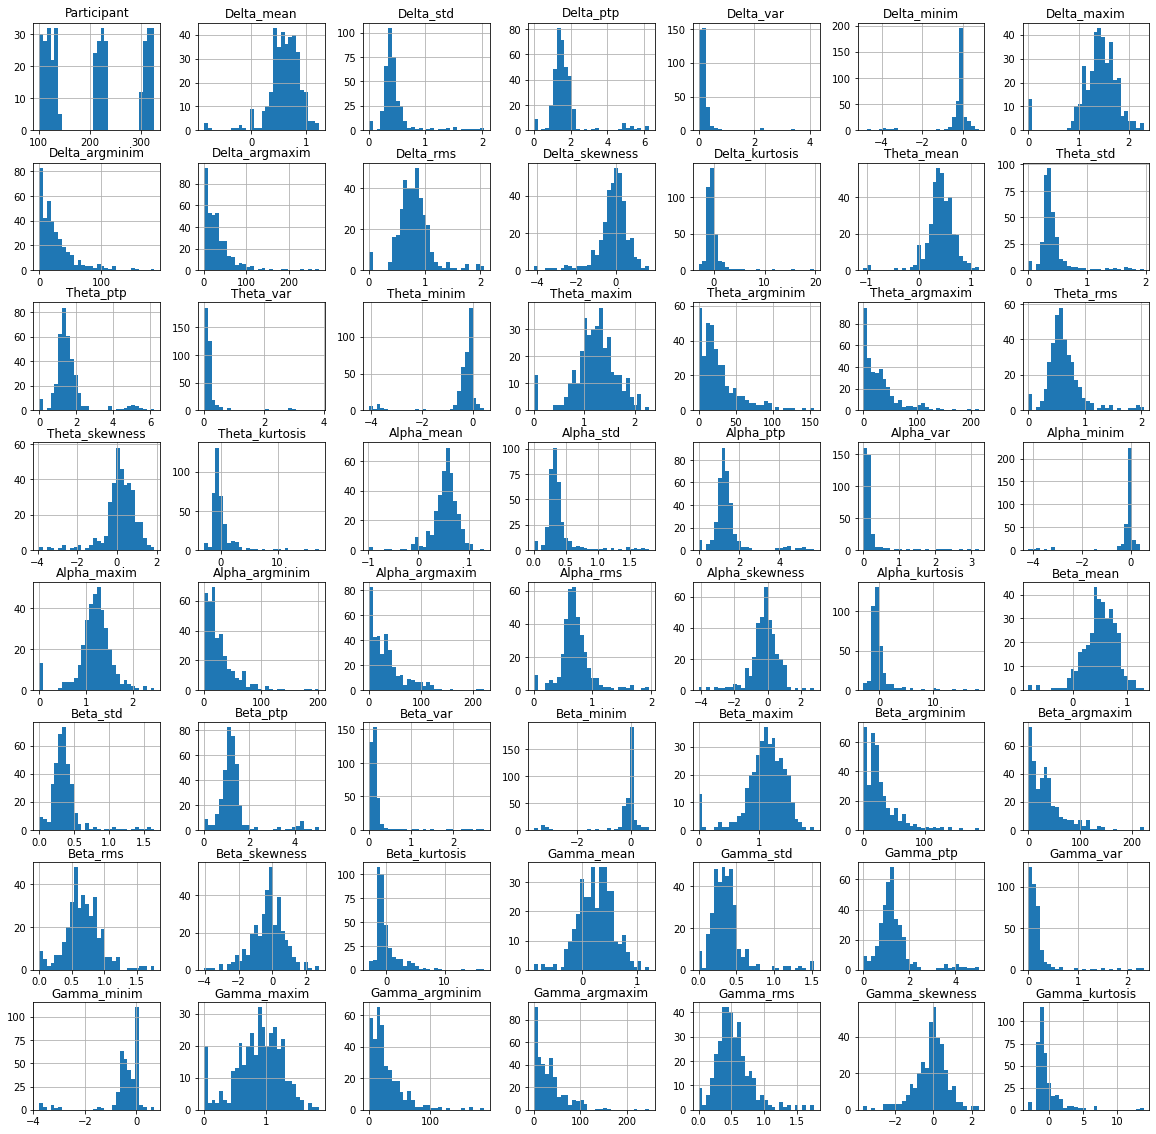

In [90]:
final_df.hist(bins = 30, figsize = (20,20))

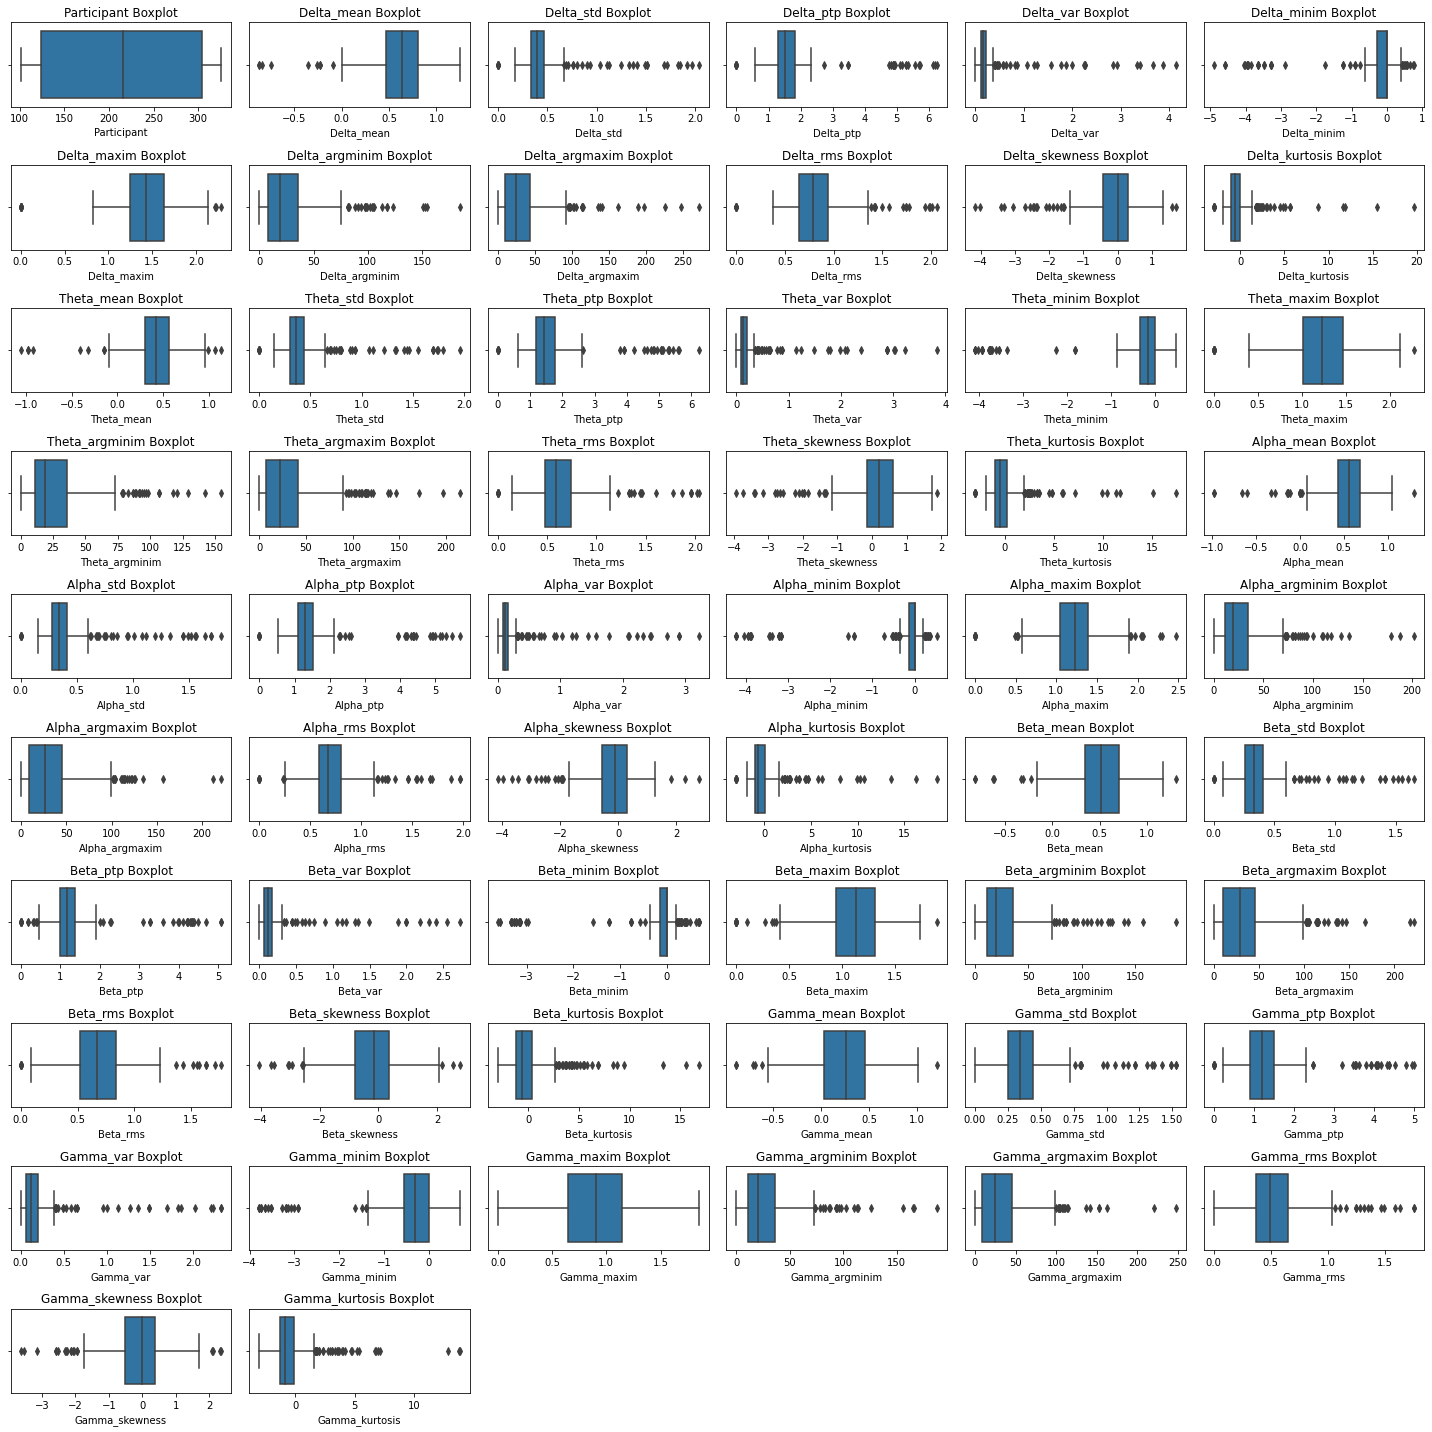

In [91]:
# Visualize the boxplot of each variable.
plt.figure(figsize=(20,20))
for i, j in enumerate(final_df.describe().columns):
    plt.subplot(10,6, i+1)
    sns.boxplot(x=final_df[j])
    plt.title('{} Boxplot'.format(j))
    plt.tight_layout()
    
plt.show()

## Visualizing the data relationship

To identify Pair the best set of features to explain a relationship between two variables, pairplot is used.

In [92]:
# This line will take a long processing time
# pairplot = sns.pairplot(final_df, corner=True,height=3)
# plt.show(pairplot)

Distribution of the features.

c:\Users\jtsan\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


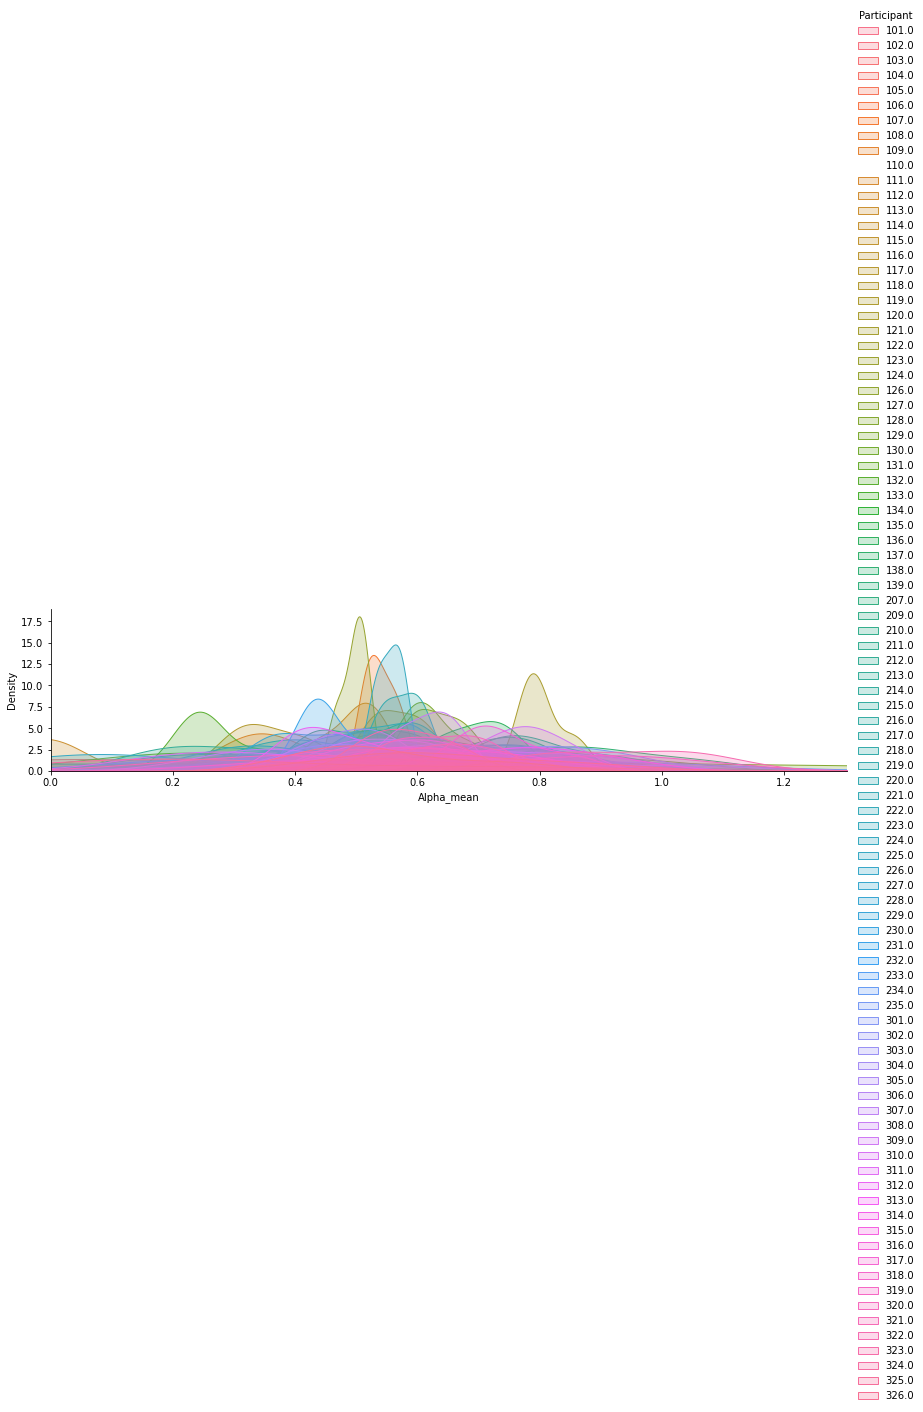

In [93]:
# make a function to plot the distribution of the features
def plot_distribution(df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue=target, aspect=4, row=row, col=col)
    facet.map(sns.kdeplot, var, shade=True)
    facet.set(xlim=(0, df[var].max()))
    facet.add_legend()
    plt.show()

# plot the distribution of the features
plot_distribution(final_df, var='Alpha_mean', target='Participant')

As we can see, the distribution of the features is not normal. We will need to normalize the data before applying the machine learning algorithms using the StandardScaler() function (see the next section).

## Check correlation

In [94]:
r_matrix = final_df.corr()
r_matrix.head()

,Participant,Delta_mean,Delta_std,Delta_ptp,Delta_var,Delta_minim,Delta_maxim,Delta_argminim,Delta_argmaxim,Delta_rms,...,Gamma_std,Gamma_ptp,Gamma_var,Gamma_minim,Gamma_maxim,Gamma_argminim,Gamma_argmaxim,Gamma_rms,Gamma_skewness,Gamma_kurtosis
Participant,1.000000,0.238136,-0.042175,-0.023050,-0.088345,0.112129,0.205398,0.071918,-0.027475,0.071783,...,-0.121347,-0.050009,-0.133000,0.084624,0.067214,0.096530,-0.023458,-0.084817,0.099409,0.092195
Delta_mean,0.238136,1.000000,-0.346664,-0.214081,-0.448986,0.510126,0.662563,0.160222,0.138585,0.236687,...,-0.286583,-0.172857,-0.458713,0.318439,0.286224,0.121846,0.084329,-0.219823,0.185124,-0.005454
Delta_std,-0.042175,-0.346664,1.000000,0.907352,0.953763,-0.877326,0.202696,-0.176883,-0.121233,0.760843,...,0.807678,0.752489,0.868492,-0.814115,-0.057079,-0.187201,-0.066996,0.635626,-0.423012,0.359767
Delta_ptp,-0.023050,-0.214081,0.907352,1.000000,0.846294,-0.916116,0.342425,-0.011739,0.028826,0.707292,...,0.786505,0.857958,0.786970,-0.868011,0.060044,-0.024959,0.112895,0.612630,-0.501841,0.556016
Delta_var,-0.088345,-0.448986,0.953763,0.846294,1.000000,-0.882414,0.038777,-0.167481,-0.123968,0.706116,...,0.806753,0.724268,0.916295,-0.806742,-0.103064,-0.180972,-0.091170,0.635886,-0.401611,0.277837


In [95]:
# r_mask = np.triu(np.ones_like(r_matrix, dtype = bool))
# from seaborn import heatmap
# plt.figure(figsize = [56,56], dpi = 100)
# plt.title('Correlatin Heatmap')
# heatmap(r_matrix, mask=r_mask, annot=True, lw=1, linecolor='White', cmap='Blues', fmt = "0.2f")

## Reviewing overall statistical information

Since the correlation matrix is difficult to read, the correlation higher than 0.5 is extracted and flattened.

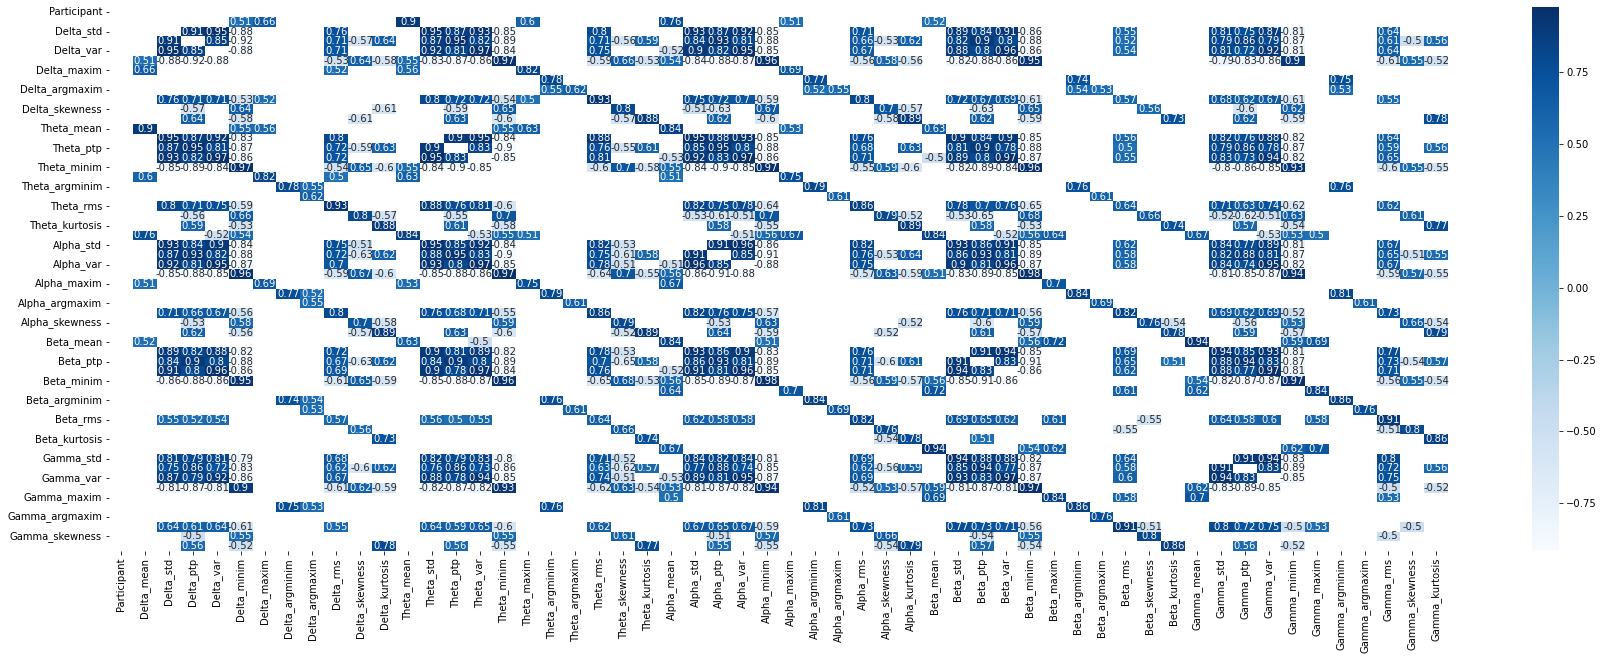

In [96]:
dfCorr = final_df.corr()
filteredDf = dfCorr[((dfCorr >= .5) | (dfCorr <= -.5)) & (dfCorr !=1.000)]
plt.figure(figsize=(30,10))
sns.heatmap(filteredDf, annot=True, cmap="Blues")
plt.show()

Pairs with correlation higher than 0.7 are listed.

In [97]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corrFilter(final_df, .7)

Delta_minim  Delta_ptp     -0.916116
Alpha_ptp    Alpha_minim   -0.910509
Beta_ptp     Beta_minim    -0.908393
Theta_minim  Theta_ptp     -0.899708
Alpha_ptp    Theta_minim   -0.895381
                              ...   
Theta_var    Alpha_var      0.970002
Beta_var     Gamma_var      0.970819
Theta_minim  Alpha_minim    0.973443
Alpha_minim  Beta_minim     0.975683
Participant  Participant         NaN
Length: 269, dtype: float64

# Pre-processing

Check the type of each variable

In [98]:
final_df.dtypes

Test               object
English            object
Gender             object
Participant       float64
Dominance          object
Delta_mean        float64
Delta_std         float64
Delta_ptp         float64
Delta_var         float64
Delta_minim       float64
Delta_maxim       float64
Delta_argminim    float64
Delta_argmaxim    float64
Delta_rms         float64
Delta_skewness    float64
Delta_kurtosis    float64
Theta_mean        float64
Theta_std         float64
Theta_ptp         float64
Theta_var         float64
Theta_minim       float64
Theta_maxim       float64
Theta_argminim    float64
Theta_argmaxim    float64
Theta_rms         float64
Theta_skewness    float64
Theta_kurtosis    float64
Alpha_mean        float64
Alpha_std         float64
Alpha_ptp         float64
Alpha_var         float64
Alpha_minim       float64
Alpha_maxim       float64
Alpha_argminim    float64
Alpha_argmaxim    float64
Alpha_rms         float64
Alpha_skewness    float64
Alpha_kurtosis    float64
Beta_mean   

We notice that are all float, exept English, Dominance, Gender and Test. Thus, to use these variables in several algorithms it is necessary to encode them as numeric.

Moreover we need to remember also that Participant is an id, and the value of this variable should not influence the result of the algorithm, so we are going to drop it.

## Split in X and y

In [99]:
y = final_df["Dominance"]
X = final_df.drop(["Dominance", "Participant"], axis=1)

## Encoding independent variables

In [100]:
obj_df = X.select_dtypes(include=['object']).copy()
obj_df.head()

,Test,English,Gender
0,LHC,Yes,Female
1,LHC,Yes,Male
2,RHS,Yes,Male
3,RHS,Yes,Male
4,LHC,Yes,Male


In [101]:
for col in obj_df.columns:
    X[col] = obj_df[col].astype('category').cat.codes
X.head()

,Test,English,Gender,Delta_mean,Delta_std,Delta_ptp,Delta_var,Delta_minim,Delta_maxim,Delta_argminim,...,Gamma_std,Gamma_ptp,Gamma_var,Gamma_minim,Gamma_maxim,Gamma_argminim,Gamma_argmaxim,Gamma_rms,Gamma_skewness,Gamma_kurtosis
0,0,1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,-3.000000
1,0,1,1,0.526442,0.294538,1.336331,0.086752,0.000000,1.336331,22.0,...,0.424252,1.609542,0.179990,-0.325524,1.284018,46.0,50.0,0.589387,0.181548,-1.023259
2,3,1,1,0.340579,0.413665,1.775144,0.171119,-0.550673,1.224472,56.0,...,0.463500,1.632933,0.214832,-0.614941,1.017991,35.0,108.0,0.638468,-0.662233,-1.064268
3,3,1,1,0.933517,0.513017,1.899951,0.263186,-0.091274,1.808677,47.0,...,0.397164,1.218180,0.157739,-0.067039,1.151140,19.0,41.0,0.682415,-0.174877,-1.284745
4,0,1,1,0.567189,0.504123,2.265507,0.254140,-0.570804,1.694703,50.0,...,0.630338,1.762350,0.397326,-0.568534,1.193816,47.0,91.0,0.761039,-0.310182,-1.689339


In [102]:
y.head()

0       Dominant
1       Dominant
2    NonDominant
3       Dominant
4    NonDominant
Name: Dominance, dtype: object

## Removing Highly Correlated Features

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5,
        55.5]),
 [Text(0, 0.5, 'Participant'),
  Text(0, 1.5, 'Delta_mean'),
  Text(0, 2.5, 'Delta_std'),
  Text(0, 3.5, 'Delta_ptp'),
  Text(0, 4.5, 'Delta_var'),
  Text(0, 5.5, 'Delta_minim'),
  Text(0, 6.5, 'Delta_maxim'),
  Text(0, 7.5, 'Delta_argminim'),
  Text(0, 8.5, 'Delta_argmaxim'),
  Text(0, 9.5, 'Delta_rms'),
  Text(0, 10.5, 'Delta_skewness'),
  Text(0, 11.5, 'Delta_kurtosis'),
  Text(0, 12.5, 'Theta_mean'),
  Text(0, 13.5, 'Theta_std'),
  Text(0, 14.5, 'Theta_ptp'),
  Text(0, 15.5, 'Theta_var'),
  Text(0, 16.5, 'Theta_minim'),
  Text(0, 17.5, 'Theta_maxim'),
  Text(0, 18.5, 'Theta_argminim'),
  Text(0, 19.5, '

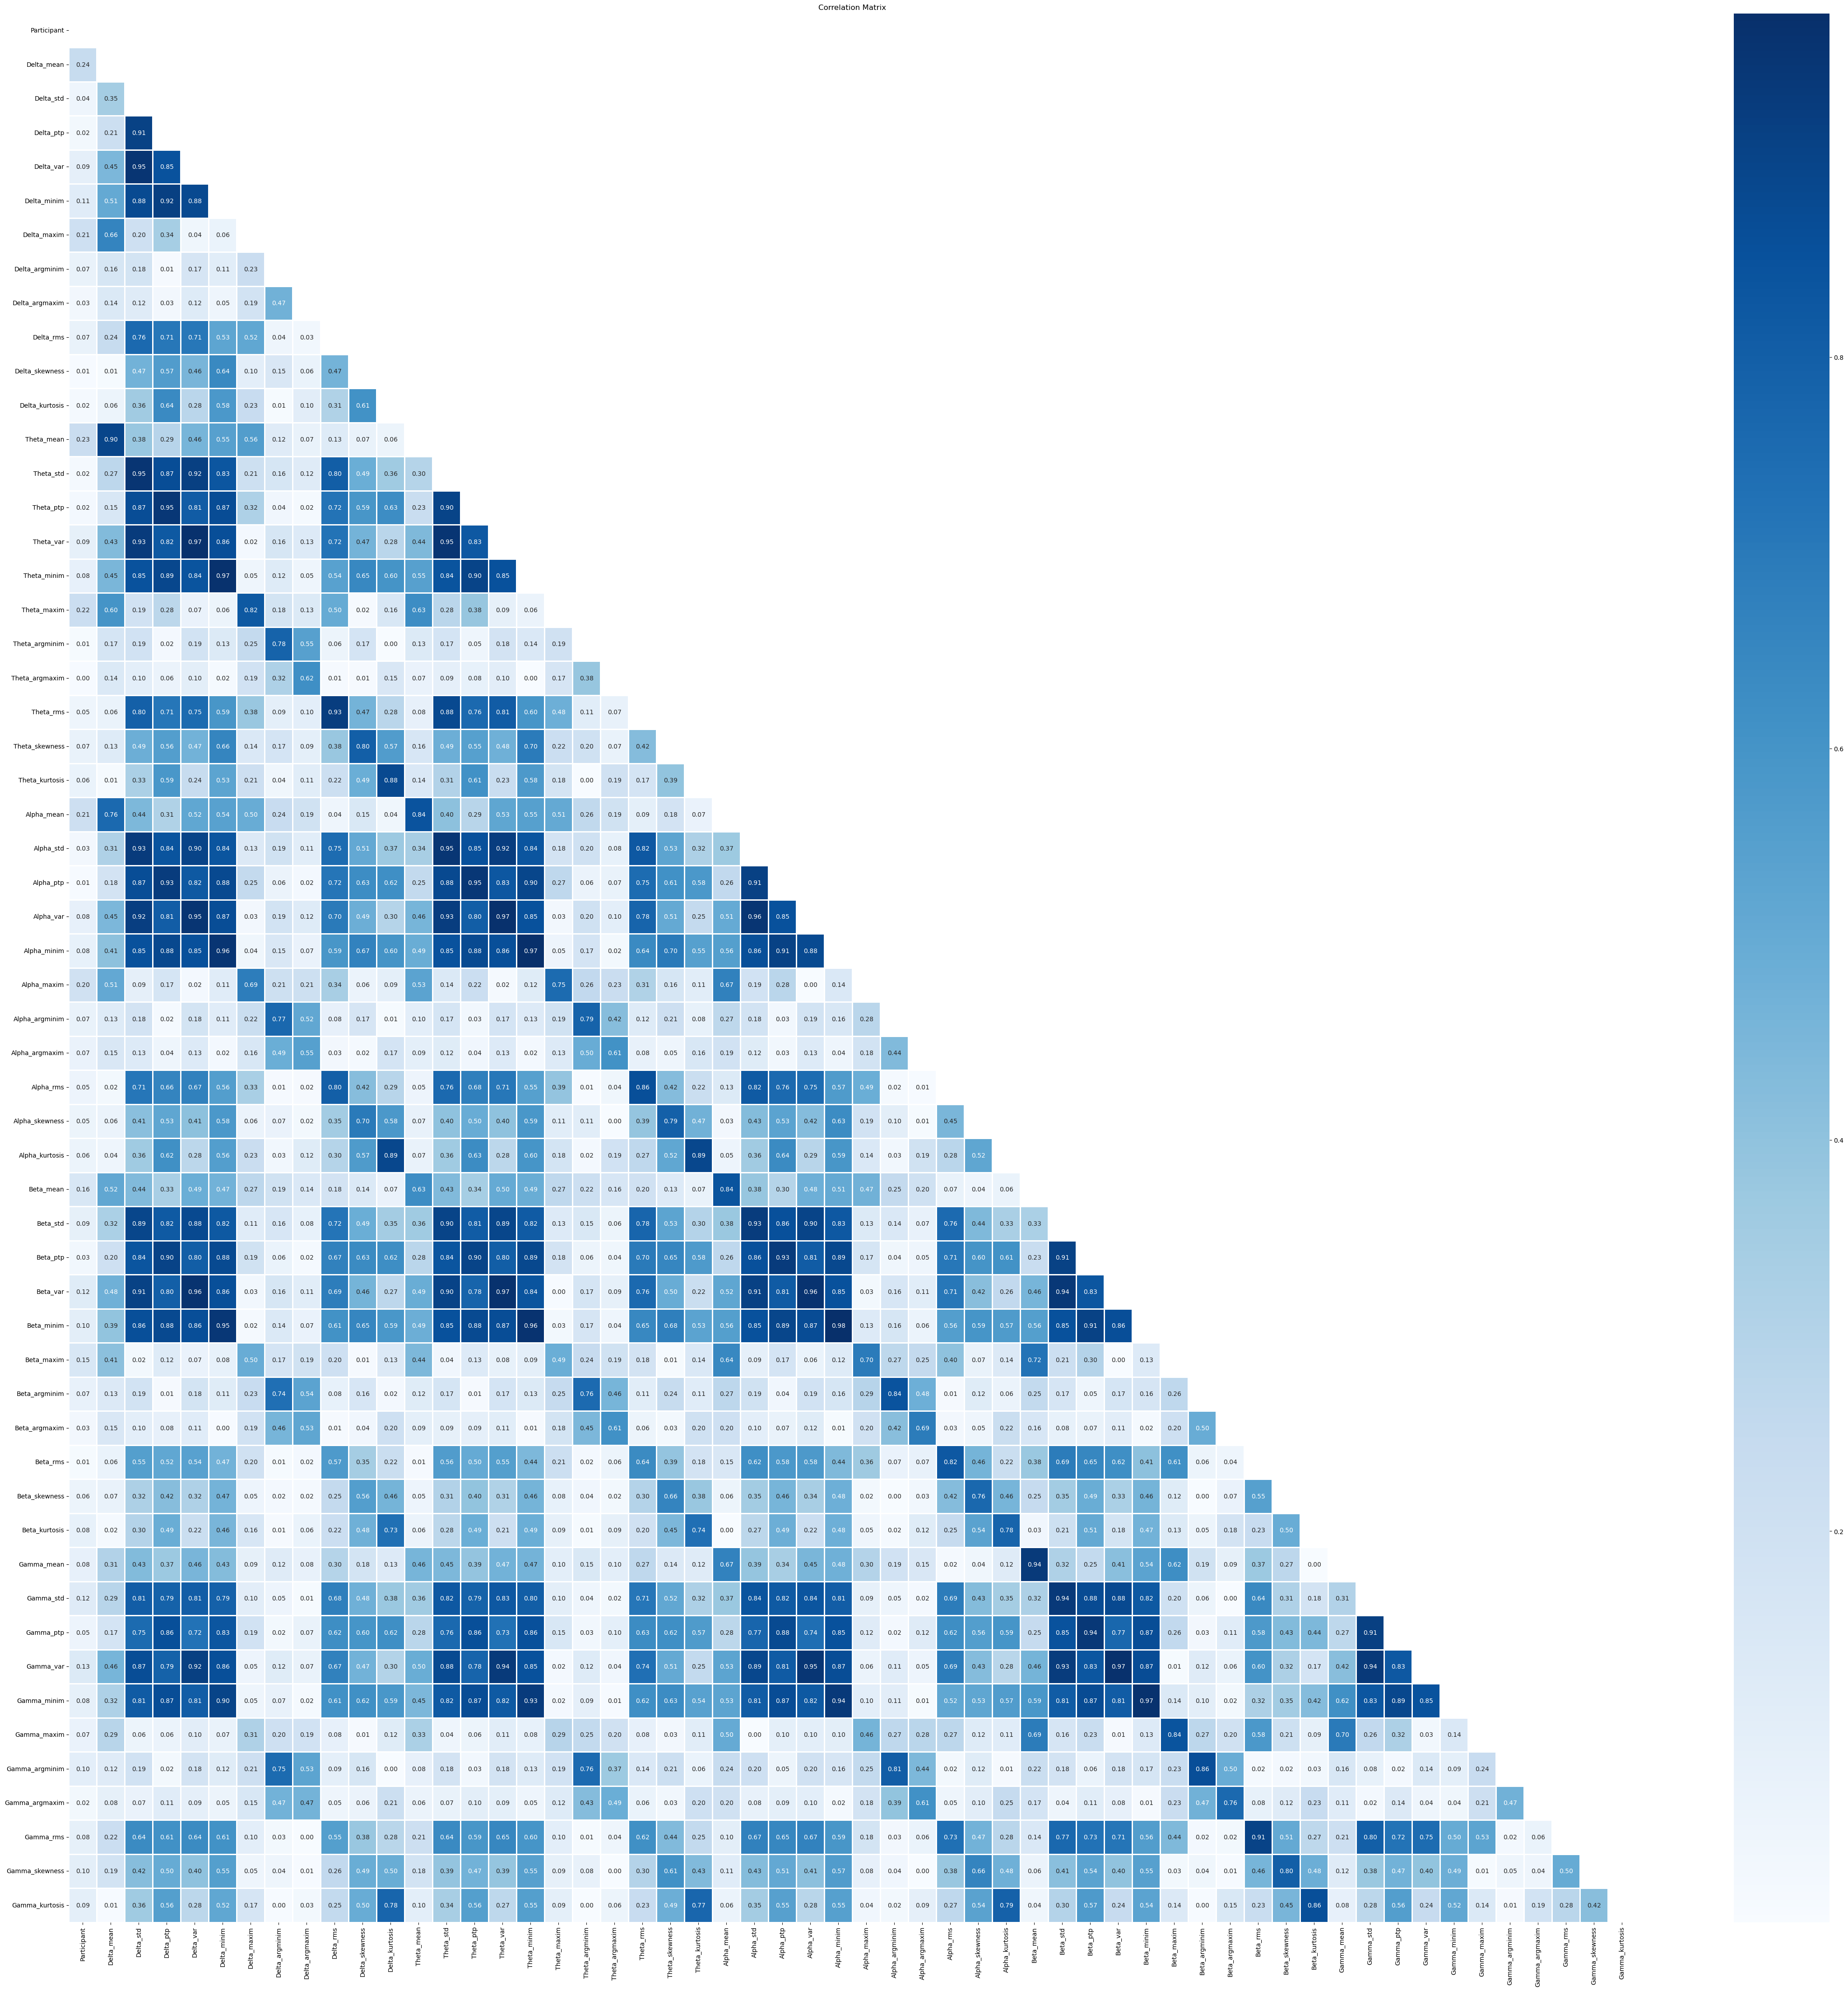

In [103]:
from seaborn import heatmap

# creating the correlation matrix
r_matrix = final_df.corr().abs()

# visualizing the correlation matrix
r_mask = np.triu(np.ones_like(r_matrix, dtype = bool))
plt.figure(figsize = [56,56], dpi = 100)
plt.title('Correlatin Heatmap')
heatmap(r_matrix, mask=r_mask, annot=True, lw=1, linecolor='White', cmap='Blues', fmt = "0.2f")
plt.title("Correlation Matrix")  # to add title 
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# getting the correlation values with the purchased column
## Start the code here
# r_matrix['Dominance'].sort_values(ascending=False)
## End

In [104]:
# drop the columns with correlation values greater than 0.9
upper_tri = r_matrix.where(np.triu(np.ones(r_matrix.shape),k=1).astype(bool))
print(upper_tri)
    
to_drop = [col for col in upper_tri.columns if any((upper_tri[col]) > 0.5)]
print(len(to_drop))

                Participant  Delta_mean  Delta_std  Delta_ptp  Delta_var  \
Participant             NaN    0.238136   0.042175   0.023050   0.088345   
Delta_mean              NaN         NaN   0.346664   0.214081   0.448986   
Delta_std               NaN         NaN        NaN   0.907352   0.953763   
Delta_ptp               NaN         NaN        NaN        NaN   0.846294   
Delta_var               NaN         NaN        NaN        NaN        NaN   
Delta_minim             NaN         NaN        NaN        NaN        NaN   
Delta_maxim             NaN         NaN        NaN        NaN        NaN   
Delta_argminim          NaN         NaN        NaN        NaN        NaN   
Delta_argmaxim          NaN         NaN        NaN        NaN        NaN   
Delta_rms               NaN         NaN        NaN        NaN        NaN   
Delta_skewness          NaN         NaN        NaN        NaN        NaN   
Delta_kurtosis          NaN         NaN        NaN        NaN        NaN   
Theta_mean  

In [105]:
# drop the columns from the dataset
X = X.drop(to_drop, axis=1)
X.head()

,Test,English,Gender,Delta_mean,Delta_std,Delta_argminim,Delta_argmaxim
0,0,1,0,0.000000,0.000000,0.0,0.0
1,0,1,1,0.526442,0.294538,22.0,46.0
2,3,1,1,0.340579,0.413665,56.0,5.0
3,3,1,1,0.933517,0.513017,47.0,6.0
4,0,1,1,0.567189,0.504123,50.0,66.0


## Split in train and test

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

print("The shape of X_train is:", X_train.shape)
print("The shape of X_test is:", X_test.shape)
print('')
print("The shape of y_train is:", y_train.shape)
print("The shape of y_test is:", y_test.shape)

The shape of X_train is: (292, 7)
The shape of X_test is: (73, 7)

The shape of y_train is: (292,)
The shape of y_test is: (73,)


## Feature scaling

In [107]:
#For label data (y) always use LabelEncoder
LaEnc = LabelEncoder()
y_train = LaEnc.fit_transform(y_train)
y_train

y_test = LaEnc.transform(y_test)
y_test

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0])

In [108]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Classification analysis

## KNN

In [109]:
KNNclassifier = KNeighborsClassifier(n_neighbors = 3, metric = 'euclidean', p = 2)
KNNclassifier.fit(X_train, y_train)

y_pred = KNNclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of KNN:", acc*100,'\n')

KNNacc = acc

Confusion Matrix
[[28  9]
 [10 26]]


Accuracy of KNN: 73.97260273972603 



## SVM linear

In [110]:
SVMclassifier = SVC(kernel = 'linear', random_state = 1)
SVMclassifier.fit(X_train, y_train)

y_pred = SVMclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of SVM linear:", acc*100,'\n')

linearSVMacc = acc

Confusion Matrix
[[31  6]
 [ 6 30]]


Accuracy of SVM linear: 83.56164383561644 



## SVM non linear

In [111]:
SVMclassifier = SVC(kernel = 'rbf', random_state = 1)
SVMclassifier.fit(X_train, y_train)

y_pred = SVMclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of SVM rbf:", acc*100,'\n')

nonlinearSVMacc = acc

Confusion Matrix
[[31  6]
 [ 8 28]]


Accuracy of SVM rbf: 80.82191780821918 



## Naive Bayes Classifier

In [112]:
NBclassifier = GaussianNB()
NBclassifier.fit(X_train, y_train)

y_pred = NBclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of Naive bayes Classifier:", acc*100,'\n')

NBacc = acc

Confusion Matrix
[[33  4]
 [15 21]]


Accuracy of Naive bayes Classifier: 73.97260273972603 



## Random Forest

In [113]:
Forestclassifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 1)
Forestclassifier.fit(X_train, y_train)

y_pred = Forestclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of random forest:", acc*100,'\n')

Forestacc = acc

Confusion Matrix
[[31  6]
 [ 6 30]]


Accuracy of random forest: 83.56164383561644 



## Decision Tree

In [114]:
DecisionTreeclassifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
DecisionTreeclassifier.fit(X_train, y_train)

y_pred = DecisionTreeclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of decision tree:", acc*100,'\n')

Decisionacc = acc

Confusion Matrix
[[27 10]
 [ 8 28]]


Accuracy of decision tree: 75.34246575342466 



## Logistic Regression Classifier

In [115]:
LRclassifier = LogisticRegression()
LRclassifier.fit(X_train, y_train)

y_pred = LRclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of logistic regression classifier:", acc*100,'\n')

LRacc = acc

Confusion Matrix
[[31  6]
 [ 6 30]]


Accuracy of logistic regression classifier: 83.56164383561644 



## LASSO Regression

In [116]:
Lassoclassifier=Lasso(alpha=0.5)
Lassoclassifier.fit(X_train, y_train)

y_pred = Lassoclassifier.predict(X_test)

#cm = confusion_matrix(y_test, y_pred)
#acc = accuracy_score(y_test, y_pred)
#print('Confusion Matrix')
#print(cm)
#print("\n")
#print("Accuracy of Lasso:", acc*100,'\n')

#LASSOacc = acc


#I am not sure how to use this regression model for classification
    #in researching it, I also came upon ridge regression, but I 
    #didn't look further into it

## Accuracy Comparison

In [120]:
print('\n'"Accuracy of KNN:", format(KNNacc*100, '.2f') + '%')
print("Accuracy of SVM linear:", format(linearSVMacc*100, '.2f')+ '%')
print("Accuracy of SVM rbf:", format(nonlinearSVMacc*100, '.2f') + '%')
print("Accuracy of Naive bayes Classifier:", format(NBacc*100, '.2f') + '%')
print("Accuracy of random forest:", format(Forestacc*100, '.2f') + '%')
print("Accuracy of decision tree:", format(Decisionacc*100, '.2f') + '%')
print("Accuracy of logistic regression:", format(LRacc*100, '.2f') + '%')


Accuracy of KNN: 73.97%
Accuracy of SVM linear: 83.56%
Accuracy of SVM rbf: 80.82%
Accuracy of Naive bayes Classifier: 73.97%
Accuracy of random forest: 83.56%
Accuracy of decision tree: 75.34%
Accuracy of logistic regression: 83.56%


# ANN Analysis

In [118]:
from sklearn.decomposition import PCA

In [122]:
PrinCom10=PCA(n_components=7)
PrinCom10.fit(X)
Z10=PrinCom10.transform(X)

In [123]:
eig = []
for z in Z10.T:
    eig.append(np.var(z))

In [124]:
contributions = []
for i in range(Z10.shape[1]):
    contributions.append(np.sum(eig[:i+1]) / np.sum(eig))

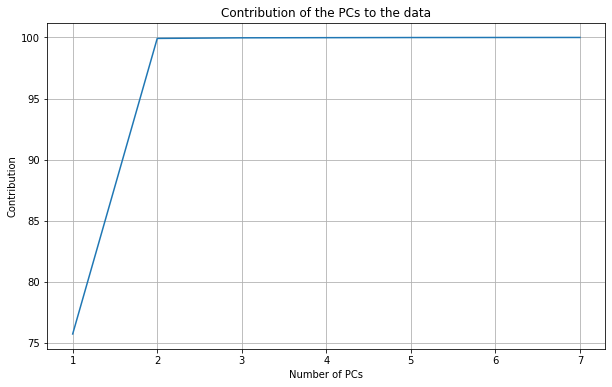

In [157]:
# plt.figure(figsize=(10,6))
# plt.plot(list(range(10, 6)), [i*100 for i in contributions])
# plt.title("Contribution of the PCs to the data")
# plt.xlabel("Number of PCs")
# plt.ylabel("Contribution")
# plt.grid()
# plt.xticks(list(range(1,11)))
# plt.show()

# plot the contribution of the PCs to the data
plt.figure(figsize=(10,6))
plt.plot(list(range(1, 8)), [i*100 for i in contributions])
plt.title("Contribution of the PCs to the data")
plt.xlabel("Number of PCs")
plt.ylabel("Contribution")
plt.grid()
plt.xticks(list(range(1,8)))
plt.show()


In [132]:
inputs= Z10[:, 0:9]

In [133]:
y_pca = LaEnc.fit_transform(y)

In [134]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(inputs, y_pca, test_size = 0.2, random_state = 3)

In [135]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [136]:
import tensorflow as tf

## Initializing the ANN

In [137]:
ANN_Model1 = tf.keras.models.Sequential()
ANN_Model2 = tf.keras.models.Sequential()
ANN_Model3 = tf.keras.models.Sequential()

## Adding the Input Layer

In [138]:
ANN_Model1.add(tf.keras.layers.Dense(units=10, activation='relu'))
ANN_Model2.add(tf.keras.layers.Dense(units=10, activation='relu'))
ANN_Model3.add(tf.keras.layers.Dense(units=10, activation='relu'))

We have created the first hidden layer by using the Dense class which is part of the layers module. This class accepts 2 inputs: units, which is the number of neurons that will be present in the respective layer and the activation which specifies which activation function to be used. We have decided to use the rectified linear unit, but there are other possibilities. 

## Adding the some Hidden Layers

For the first model let's try with a large hidden layer:

In [139]:
ANN_Model1.add(tf.keras.layers.Dense(units=64, activation='relu'))

One way to procede is to have the second hidden layer that is the double of the first one, so let's try it in the second model:

In [140]:
ANN_Model2.add(tf.keras.layers.Dense(units=22, activation='relu'))

While, for the third model, let's try to have more than just one hidden layer:

In [141]:
ANN_Model3.add(tf.keras.layers.Dense(units=6, activation='relu'))

## Adding the Output Layer

In this project, we have only two classes. So, in a binary classification problem (like this one), we will be allocating only one neuron (unit=1) to output this result. For the multiclass classification problem, we have to use more than one neuron in the output layer.

For the binary classification problems, the activation function that should be used is sigmoid, while for a multiclass classification problem, the activation function that should be used is softmax.

In [142]:
ANN_Model1.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
ANN_Model2.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
ANN_Model3.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## Compiling the ANN

Now I need to compile the ANN.

In [143]:
ANN_Model1.compile(optimizer='adam', loss='binary_crossentropy',  metrics = ['accuracy'])
ANN_Model2.compile(optimizer='adam', loss='binary_crossentropy',  metrics = ['accuracy'])
ANN_Model3.compile(optimizer='adam', loss='binary_crossentropy',  metrics = ['accuracy'])

## Training the ANN

In [144]:
h1 = ANN_Model1.fit(X_train, y_train, validation_split=0.2, batch_size = 32, epochs = 200)
h2 = ANN_Model2.fit(X_train, y_train, validation_split=0.2, batch_size = 32, epochs = 200)
h3 = ANN_Model3.fit(X_train, y_train, validation_split=0.2, batch_size = 32, epochs = 200)

Epoch 1/200
8/8 [==============================] - 0s 16ms/step - loss: 0.6782 - accuracy: 0.5579 - val_loss: 0.6847 - val_accuracy: 0.5593
Epoch 2/200
8/8 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.6223 - val_loss: 0.6746 - val_accuracy: 0.6271
Epoch 3/200
8/8 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.7210 - val_loss: 0.6673 - val_accuracy: 0.6102
Epoch 4/200
8/8 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.7167 - val_loss: 0.6608 - val_accuracy: 0.6102
Epoch 5/200
8/8 [==============================] - 0s 3ms/step - loss: 0.6164 - accuracy: 0.7468 - val_loss: 0.6568 - val_accuracy: 0.6441
Epoch 6/200
8/8 [==============================] - 0s 3ms/step - loss: 0.6041 - accuracy: 0.7468 - val_loss: 0.6532 - val_accuracy: 0.6271
Epoch 7/200
8/8 [==============================] - 0s 4ms/step - loss: 0.5926 - accuracy: 0.7554 - val_loss: 0.6484 - val_accuracy: 0.6102
Epoch 8/200
8/8 [=========

### Plotting learning curves

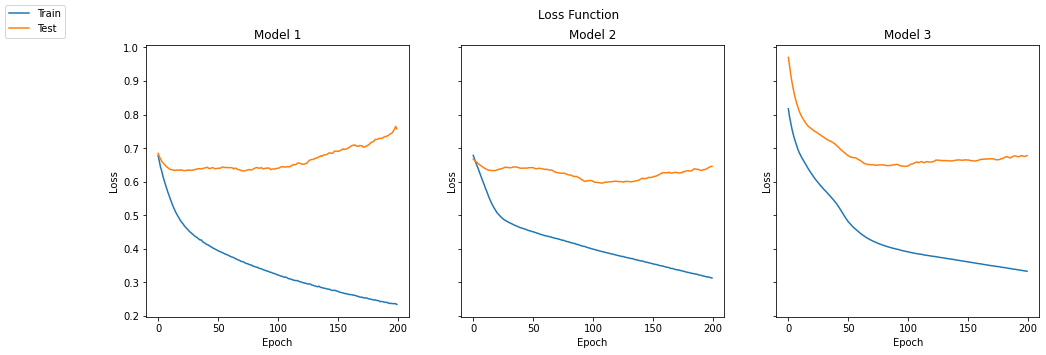

In [145]:
from matplotlib import legend
h = [h1, h2, h3]
fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize = (16,5))
fig.suptitle('Loss Function')
for i in range(3):
  axs[i].plot(h[i].history['loss'])
  axs[i].plot(h[i].history['val_loss'])
  axs[i].set_title("Model {}".format(i + 1))

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss')

fig.legend(labels=['Train','Test'], loc="upper left")
plt.show()

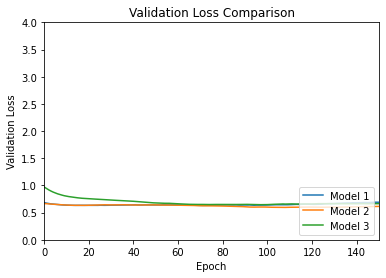

In [146]:
for i in range(3):
  plt.plot(h[i].history['val_loss'])

plt.title('Validation Loss Comparison')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.xlim(0, 150)
plt.ylim(0, 4)
plt.legend(['Model 1', 'Model 2', 'Model 3'], loc='lower right')
plt.show()

## Evaluating the Model

In [147]:
models = [ANN_Model1, ANN_Model2, ANN_Model3]

In [148]:
y_pred1 = ANN_Model1.predict(X_test)
y_pred2 = ANN_Model2.predict(X_test)
y_pred3 = ANN_Model3.predict(X_test)

3/3 [==============================] - 0s 997us/step


In [149]:
accurancy = []
for model in models:
    accurancy.append(model.evaluate(X_test,y_test))
for i in range(len(accurancy)):
    print ("The accurancy of model", i + 1, "is", accurancy[i][1]*100, "%")

3/3 [==============================] - 0s 997us/step - loss: 0.3130 - accuracy: 0.8904
The accurancy of model 1 is 79.45205569267273 %
The accurancy of model 2 is 91.78082346916199 %
The accurancy of model 3 is 89.04109597206116 %


## Cross Validation

In [150]:
tf.__version__

'2.10.0'

In [151]:
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict 
predictions = []
keras_classifier = []
for model in models:
    keras_classifier.append(KerasClassifier(model = model, optimizer="adam", epochs=100, verbose=0))
for classifier in keras_classifier:
    predictions.append (cross_val_predict(classifier, X_train, y_train, cv=3))

INFO:tensorflow:Assets written to: C:\Users\jtsan\AppData\Local\Temp\tmpyg_euq20\assets
INFO:tensorflow:Assets written to: C:\Users\jtsan\AppData\Local\Temp\tmpks2jrx0y\assets
INFO:tensorflow:Assets written to: C:\Users\jtsan\AppData\Local\Temp\tmpc06m1pyo\assets
INFO:tensorflow:Assets written to: C:\Users\jtsan\AppData\Local\Temp\tmpxsj4kddk\assets
INFO:tensorflow:Assets written to: C:\Users\jtsan\AppData\Local\Temp\tmpgi2jorcs\assets
INFO:tensorflow:Assets written to: C:\Users\jtsan\AppData\Local\Temp\tmpnhatg4d6\assets
INFO:tensorflow:Assets written to: C:\Users\jtsan\AppData\Local\Temp\tmp5kuuu8rz\assets
INFO:tensorflow:Assets written to: C:\Users\jtsan\AppData\Local\Temp\tmpredf659y\assets
INFO:tensorflow:Assets written to: C:\Users\jtsan\AppData\Local\Temp\tmpwile8bno\assets


In [152]:
scores = []
cv_accurancy = []
for classifier in keras_classifier:
    scores.append(cross_val_score(classifier, X_train, y_train, scoring='accuracy', cv=5, verbose=0))

INFO:tensorflow:Assets written to: C:\Users\jtsan\AppData\Local\Temp\tmp2ggv_9hs\assets
INFO:tensorflow:Assets written to: C:\Users\jtsan\AppData\Local\Temp\tmpdn0m0dgw\assets
INFO:tensorflow:Assets written to: C:\Users\jtsan\AppData\Local\Temp\tmp3gfvmokz\assets
INFO:tensorflow:Assets written to: C:\Users\jtsan\AppData\Local\Temp\tmp37skn1un\assets
INFO:tensorflow:Assets written to: C:\Users\jtsan\AppData\Local\Temp\tmpt9_qubqs\assets
INFO:tensorflow:Assets written to: C:\Users\jtsan\AppData\Local\Temp\tmpl5j6y6e0\assets
INFO:tensorflow:Assets written to: C:\Users\jtsan\AppData\Local\Temp\tmp97uicaph\assets
INFO:tensorflow:Assets written to: C:\Users\jtsan\AppData\Local\Temp\tmp95nmw_wh\assets
INFO:tensorflow:Assets written to: C:\Users\jtsan\AppData\Local\Temp\tmp51qk7uoq\assets
INFO:tensorflow:Assets written to: C:\Users\jtsan\AppData\Local\Temp\tmpqq9n8u2r\assets
INFO:tensorflow:Assets written to: C:\Users\jtsan\AppData\Local\Temp\tmp5hopxpb_\assets
INFO:tensorflow:Assets written t

In [153]:
for i in range(len(scores)):
    cv_accurancy.append(np.average(scores[i])*100)
    print('The averaged prediction accuracy of model ', i+1, 'is equal to', round(cv_accurancy[i],4),"%") 

The averaged prediction accuracy of model  1 is equal to 77.3641 %
The averaged prediction accuracy of model  2 is equal to 78.0538 %
The averaged prediction accuracy of model  3 is equal to 81.4728 %
